# TWVRP: Problema de enrutamiento de vehículos con ventanas temporales.

Antes que nada, se crea dentro de cualquier directorio un entorno virtual python con `mkvirtualenv JoseAndres -p python3`. El kernel JoseAndres va sin ningun paquete que debeos ir cargando con pip. Tambien se puede hacer en anaconda pero yo no lo utilizo.

1. Se instalan los packages necesarios dentro del virtual environment creado con `mkvirtualenv JoseAndres  -p python3`

In [16]:
%pip install --upgrade pip
%pip install gurobipy
%pip install numpy
%pip install matplotlib
%pip install nbconvert
%pip install jupyter_contrib_nbextensions

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached jupyter_contrib_nbextensions-0.7.0.tar.gz (23.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached jupyter_contrib_core-0.4.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Using cached jupyter_highlight_selected_word-0.2.0-py2.py3-none-any.whl (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.9/466.9 kB 5.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for jupyter_contrib_nbextensions: filename=jupyter_contrib_nbextensions-0.7.0-py2.py3-none-any.whl size=23428784 sha256=e4e70a100328d495bbfdc0e74e51f0bd897f2a44bcadc9726acc07323f5eab98
  S

In [2]:
from gurobipy import *  # es el modelo de optimización y hay que cargarlo con pip (ver celda de arriba)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import cycle
import random

In [3]:
# Nodos
n = 11 # Número de nodos
clientes = [i for i in range(n) if i!=0] # Un conjunto de clientes que no incluye el valor "0"
nodos = [0] + clientes # Un conjunto de nodos, que son el número de clientes mas "0"
arcos = [(i, j) for i in nodos for j in nodos if i!=j] # Todos los arcos entre dos puntos


In [4]:
# Demanda
np.random.seed(0)
q = {n:np.random.randint(10, 15) for n in clientes}
q[0] = 0 # El nodo 0 no tiene demanda

In [5]:
# Ventanas temporales
e = {0:0, 1:10, 2:10, 3:10, 4:20, 5:20, 6:20, 7:40, 8:40, 9:40, 10:40} # Mínimo tiempo de llegada
l = {0:200, 1:100, 2:100, 3:100, 4:150, 5:150, 6:150, 7:180, 8:180, 9:180, 10:180} # Máximo tiempo de llegada
# El formato es -> numero_nodo:tiempo_entrega
# Por ejemplo, 2:10 indica que el mínimo tiempo de llegada al nodo 2 es de 10 minutos.
# Como 0 es el depot, tiene como hora m�xima de llegada el mayor valor de todos, ya que es el último nodo cuando acaba la jornada laboral

s = {n:np.random.randint(3,5) for n in clientes} # Tiempo de servicio en el nodo i
# Valor aleatorio entre 3 y 5 minutos para la entrega de los productos en cada nodo
s[0] = 0 # El tiempo de servicio en el nodo "0" es 0

In [6]:
# Vehículos
vehiculos = [1, 2, 3, 4]

#Q = 50
Q = {1:50, 2:50, 3:25, 4:25} # Cada vehículo(1, 2, 3, 4) y su capacidad (25 o 50)

In [7]:
# Coordenadas
X = np.random.rand(len(nodos))*100
Y = np.random.rand(len(nodos))*100

In [8]:
# Definicion de distancias y tiempos
distancia = {(i, j): np.hypot(X[i] - X[j], Y[i] - Y[j]) for i in nodos for j in nodos if i!=j}
tiempo = {(i, j): np.hypot(X[i] - X[j], Y[i] - Y[j]) for i in nodos for j in nodos if i!=j}
# Por simplicidad voy a asumir que la distancia y el tiempo son iguales.

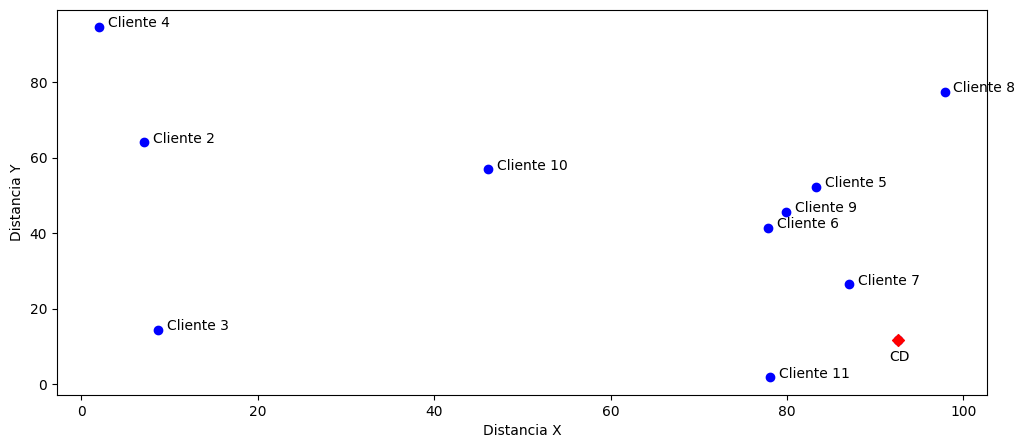

In [9]:
plt.figure(figsize=(12, 5))
plt.scatter(X, Y, color = 'blue') # Puntos de entrega en azul

# Centro de distribuci�n
plt.scatter(X[0], Y[0], color = 'red', marker = 'D') # Depot en rojo, marcado como un diamante
plt.annotate("CD", (X[0] - 1, Y[0] - 5.5), fontsize = 10)
# Cada {%d} corresponde con los valores (0, e[0], l[0]), EN ORDEN
# Cuando escribo t_{%d}$, "_" indica que el valor ser� sub�ndice de t
for i in clientes:
    plt.annotate(f'Cliente {i+1}', (X[i] + 1, Y[i]), fontsize = 10)
# Como se ha explicado antes: $q_{i}=%q[i] | $t_{i}$=(e[i],l[i])

plt.xlabel("Distancia X")
plt.ylabel("Distancia Y")
# plt.title("Nodos Problema de Ruteo de Veh�culos con Ventanas Temporales")

plt.show()

In [10]:
# Creación de los arcos
arco_var = [(i, j, k) for i in nodos for j in nodos for k in vehiculos if i!=j]
arco_tiempos = [(i, k) for i in nodos for k in vehiculos]

In [11]:
# Modelo  aqui fallaba porque no cargabais el gurobipy (modelo de optimización VRPTW)
model = Model('VRPTW')

Restricted license - for non-production use only - expires 2024-10-28


In [12]:
# Variables de decisión
x = model.addVars(arco_var, vtype=GRB.BINARY, name = 'x')
t = model.addVars(arco_tiempos, vtype=GRB.CONTINUOUS, name = 't')

# Función objetivo
model.setObjective(quicksum(distancia[i, j] * x[i, j, k] for i, j, k in arco_var), GRB.MINIMIZE)


In [13]:
# Restricciones
# 1. Llegadas y salidas del centro de distribución
model.addConstrs(quicksum(x[0, j ,k] for j in clientes) <= 1 for k in vehiculos) 
model.addConstrs(quicksum(x[i, 0 ,k] for i in clientes) <= 1 for k in vehiculos) 

# 2. Un veh�culo por nodo
model.addConstrs(quicksum(x[i, j, k] for j in nodos for k in vehiculos if i!=j) == 1 for i in clientes)

# 3. Conservaci�n de flujo
model.addConstrs(quicksum(x[i, j, k] for j in nodos if i!=j) - quicksum(x[j, i, k] for j in nodos if i!=j) == 0 for i in nodos for k in vehiculos)

# 4. Capacidad del vehículo
model.addConstrs(quicksum(q[i]*quicksum(x[i, j, k] for j in nodos if i!=j) for i in clientes) <= Q[k] for k in vehiculos)

# 5. Ventana de tiempo
model.addConstrs((x[i, j, k] == 1) >> (t[i, k] + s[i] + tiempo[i, j] == t[j, k]) for i in clientes for j in clientes for k in vehiculos if i!=j)

model.addConstrs(t[i, k] >= e[i] for i, k in arco_tiempos)
model.addConstrs(t[i, k] <= l[i] for i, k in arco_tiempos)

{(0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 4): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 4): <gurobi.Constr *Awaiting Model Update*>,
 (2, 1): <gurobi.Constr *Awaiting Model Update*>,
 (2, 2): <gurobi.Constr *Awaiting Model Update*>,
 (2, 3): <gurobi.Constr *Awaiting Model Update*>,
 (2, 4): <gurobi.Constr *Awaiting Model Update*>,
 (3, 1): <gurobi.Constr *Awaiting Model Update*>,
 (3, 2): <gurobi.Constr *Awaiting Model Update*>,
 (3, 3): <gurobi.Constr *Awaiting Model Update*>,
 (3, 4): <gurobi.Constr *Awaiting Model Update*>,
 (4, 1): <gurobi.Constr *Awaiting Model Update*>,
 (4, 2): <gurobi.Constr *Awaiting Model Update*>,
 (4, 3): <gurobi.Constr *Awaiting Model Update*>,
 (4, 4): <gurobi.Constr *Awaiting Model Update*>,


In [14]:
# Calcula la solución mas optima 

model.optimize()


Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i9-10900X CPU @ 3.70GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 154 rows, 484 columns and 1848 nonzeros
Model fingerprint: 0x4eb22e20
Model has 360 general constraints
Variable types: 44 continuous, 440 integer (440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
  GenCon rhs range [8e+00, 1e+02]
  GenCon coe range [1e+00, 1e+00]
Presolve added 414 rows and 0 columns
Presolve removed 0 rows and 64 columns
Presolve time: 0.06s
Presolved: 568 rows, 420 columns, 4042 nonzeros
Variable types: 102 continuous, 318 integer (318 binary)
Found heuristic solution: objective 851.1598825

Root relaxation: objective 2.949996e+02, 75 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

Función objetivo: 587.21
x[0,3,2]=1.0
x[0,5,3]=1.0
x[0,6,4]=1.0
x[0,9,1]=1.0
x[1,2,2]=1.0
x[2,10,2]=1.0
x[3,1,2]=1.0
x[4,0,1]=1.0
x[5,8,3]=1.0
x[6,0,4]=1.0
x[7,4,1]=1.0
x[8,0,3]=1.0
x[9,7,1]=1.0
x[10,0,2]=1.0
t[1,1]=100.0
t[1,2]=47.31715519507497
t[1,3]=10.0
t[1,4]=10.0
t[2,1]=10.0
t[2,2]=100.0
t[2,3]=10.0
t[2,4]=100.0
t[3,1]=100.0
t[3,2]=13.421570625124822
t[3,3]=10.000000000000002
t[3,4]=10.0
t[4,1]=150.0000000000001
t[4,2]=20.000000000000014
t[4,3]=150.0
t[4,4]=150.0
t[5,1]=150.0
t[5,2]=150.00000000000006
t[5,3]=150.0
t[5,4]=20.0
t[6,1]=150.0
t[6,2]=20.0
t[6,3]=150.0
t[6,4]=20.0
t[7,1]=116.84285081574512
t[7,2]=40.00000000000001
t[7,3]=39.99999999999997
t[7,4]=40.0
t[8,1]=40.000000000000114
t[8,2]=40.0
t[8,3]=157.65012134249957
t[8,4]=40.0
t[9,1]=58.18440511058404
t[9,2]=40.0
t[9,3]=39.99999999999997
t[9,4]=40.0
t[10,1]=40.0
t[10,2]=173.44994330265786
t[10,3]=39.99999999999997
t[10,4]=39.99999999999999
[[0, 9, 7, 4, 0], [0, 3, 1, 2, 10, 0], [0, 5, 8, 0], [0, 6, 0]]
[1, 2, 3, 4]


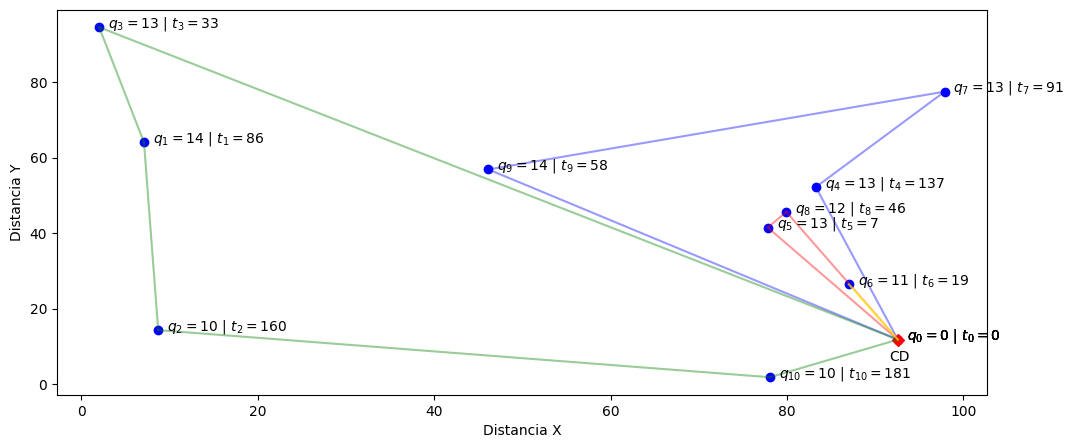

In [15]:
# Imprimir la solución
print("Función objetivo:", str(round(model.ObjVal, 2)))
for v in model.getVars():
    if v.x > 0.9:
        print(str(v.VarName)+"="+str(v.x))
        
# Graficar la solución
rutas = []
truck = []
K = vehiculos
N = nodos
for k in vehiculos:
    for i in nodos:
        if i!=0 and x[0, i, k].x > 0.9:
            aux = [0, i]
            while i!=0:
                j = i
                for h in nodos:
                    if j!=h and x[j, h, k].x > 0.9:
                        aux.append(h)
                        i = h
            rutas.append(aux)
            truck.append(k)
print(rutas)
print(truck)

# Acumulacion de tiempos
tiempo_acum = list()
for n in range(len(rutas)):
    for k in range(len(rutas[n])-1):
        if k == 0:
            aux = [0]
        else:
            i = rutas[n][k]
            j = rutas[n][k + 1]
            t = tiempo[i, j] + s[i] + aux[-1] 
            aux.append(t)
    tiempo_acum.append(aux)

# Gráfica solución
plt.figure(figsize=(12, 5))
plt.scatter(X, Y, color = 'blue')


# Centro de distribución
plt.scatter(X[0], Y[0], color = 'red', marker = 'D') 
plt.annotate("CD", (X[0] - 1, Y[0] - 5.5), fontsize = 10)

# Representación de las rutas
Color = ['blue', 'green', 'red', 'yellow', 'purple', 'orange', 'black', 'brown']


for r in range(len(rutas)):
    for n in range(len(rutas[r])-1): # Debido a que el último punto será j y no puede ser n + 1
        i = rutas[r][n]
        j = rutas[r][n + 1]
        plt.plot([X[i], X[j]], [Y[i], Y[j]], color = Color[r] ,alpha = 0.4)
    
for r in range(len(tiempo_acum)):
    for n in range(len(tiempo_acum[r])):
        i = rutas[r][n]
        plt.annotate('$q_{%d} = %d$ | $t_{%d} = %d$' %(i, q[i], i, tiempo_acum[r][n]), (X[i]+1, Y[i]), fontsize = 10)
    
patch = [mpatches.Patch(color = Color[n], label = "vehículo "+str(truck[n])+ " | cap = "+str(Q[truck[n]])) for n in range(len(truck))]

# plt.legend(handles=patch, loc='best')
plt.xlabel("Distancia X")
plt.ylabel("Distancia Y")
# plt.title("Problema de Ruteo de Vehículos con Ventanas Temporales")

plt.show()
